In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tqdm
from scipy.signal import find_peaks
from numba import jit, njit, vectorize, guvectorize, float64

plt.style.use(['science', 'grid', 'notebook'])

# Sinapsis de 2 Neuoronas de Hodgkin-Huxley

Definición de constantes y de ecuaciones del sistema

In [2]:
# Definición de constantes del sistema
Vna = 50    # mV
Vk = -77
Vl = -54.4
Vsyn = 0
gna = 120   # mS/cm^2
gk = 36
gl = 0.3

tau_s = 3  # ms (constante de tiempo de la sinapsis)

C = 1   # microF/cm^2

# Definición de funciones de comportamiento de la membrana

@njit
def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-0.1 * (V + 40)))
@njit
def beta_m(V):
    return 4 * np.exp(-(V + 65) / 18)
@njit
def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)
@njit
def beta_h(V):
    return 1 / (1 + np.exp(-0.1 * (V + 35)))
@njit
def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))
@njit
def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

@njit
def x_inf(V):
    v_len = V.shape[0]
    res = np.empty((4, v_len))

    for i in range(v_len):
        res[:, i] = np.array([alpha_m(V[i]) / (alpha_m(V[i]) + beta_m(V[i])), alpha_h(V[i]) / (alpha_h(V[i]) + beta_h(V[i])), alpha_n(V[i]) / (alpha_n(V[i]) + beta_n(V[i])), 0.5*(1 + np.tanh(V[v_len-i-1]/5))])

    return res
    # return np.array([alpha_m(V) / (alpha_m(V) + beta_m(V)), alpha_h(V) / (alpha_h(V) + beta_h(V)), alpha_n(V) / (alpha_n(V) + beta_n(V)), 0.5*(1 + np.tanh(V[::-1]/5))])  # Se agrega la variable de estado de la sinapsis

@njit
def tau_x(V):
    v_len = V.shape[0]
    res = np.empty((4, v_len))

    for i in range(v_len):
        res[:, i] = np.array([1 / (alpha_m(V[i]) + beta_m(V[i])), 1 / (alpha_h(V[i]) + beta_h(V[i])), 1 / (alpha_n(V[i]) + beta_n(V[i])), tau_s])

    return res

    # return np.array([1 / (alpha_m(V) + beta_m(V)), 1 / (alpha_h(V) + beta_h(V)), 1 / (alpha_n(V) + beta_n(V)), tau_s*np.ones_like(V)])  # Se agrega la variable de estado de la sinapsis

Función para resolver ecuaciones diferenciales mediante método de Euler

In [3]:
@jit(forceobj=True, parallel=True)
def euler_eq_resolver(seed, time_limits, delta_t, dydx, args):
    time_axis = np.arange(*time_limits, delta_t)    # defino eje temporal
    results = np.empty((time_axis.size, *seed.shape))            # defino matriz de potencial de membrana y variables de comportamiento
    # print(results.shape)
    results[0] = np.copy(seed)    # copio condiciones iniciales

    for i in range(1, time_axis.size):
        results[i] = results[i - 1] + delta_t * dydx(results[i - 1], args)
    return results

Defino las derivadas

In [63]:
N_neurons = 2

delta_t = 0.01
time_limits = (0, 4000)

V_seed = np.array([-60, -70])
seed = np.array([V_seed, *x_inf(0.9*V_seed)]) # la condicion inicial cerca del potencial de reposo
print(seed)
print(seed.shape)

@njit
def dVdt(V, m, h, n, s, args):
    gna, gk, gl, gsyn, Vna, Vk, Vl, Vsyn, I = args
    return (I - gna * m**3 * h * (V - Vna) - gk * n**4 * (V - Vk) - gl * (V - Vl) - gsyn * s * (V - Vsyn) ) / C
@njit
def dxdt(x, V):
    return (x_inf(V) - x) / tau_x(V)

# @njit
@jit(forceobj=True)
def derivate_system(x, args):
    return np.array([dVdt(x[0], *x[1:], args), *dxdt(x[1:], x[0])])


[[-6.00000000e+01 -7.00000000e+01]
 [ 1.74285249e-01  6.68181110e-02]
 [ 2.36877891e-01  5.24922526e-01]
 [ 4.90985931e-01  3.48720210e-01]
 [ 1.13704601e-11  4.16139734e-10]]
(5, 2)


Implemento para diferentes valores de $g_\text{syn}$, tanto para excitatorio como para inhibitorio

In [65]:
gsyn_limits = (0, 2)
N_gsyn_points = 30
gsyn_values = np.linspace(*gsyn_limits, N_gsyn_points)


results_exc = np.empty((N_gsyn_points, int((time_limits[1] - time_limits[0]) / delta_t), *seed.shape))
results_inbh = np.empty((N_gsyn_points, int((time_limits[1] - time_limits[0]) / delta_t), *seed.shape))

for i, gsyn in enumerate(tqdm.tqdm(range(N_gsyn_points))):
    args = (gna, gk, gl, gsyn, Vna, Vk, Vl, 0, 10)
    results_exc[i] = euler_eq_resolver(seed, time_limits, delta_t, derivate_system, args)
    args = (gna, gk, gl, gsyn, Vna, Vk, Vl, -80, 10)
    results_inbh[i] = euler_eq_resolver(seed, time_limits, delta_t, derivate_system, args)

print(results_exc.shape, results_inbh.shape)

100%|██████████| 30/30 [03:37<00:00,  7.24s/it]

(30, 400000, 5, 2) (30, 400000, 5, 2)


Busco los picos para encontrar el desfasaje y la tasa de disparo

In [89]:
plot_e = False
plot_i = False

time_axis = np.arange(*time_limits, delta_t)
desfasajes_exc = np.empty(N_gsyn_points)
desfasajes_inbh = np.empty(N_gsyn_points)
tasa_disparo_exc = np.empty(N_gsyn_points)
tasa_disparo_inbh = np.empty(N_gsyn_points)

n_peaks = 10

print(results_exc.shape)

x_lims = (2500, 4000)

for i, gsyn in enumerate(gsyn_values):
    peaks_e = np.empty((N_neurons, ), dtype=object)
    peaks_i = np.empty((N_neurons, ), dtype=object)
    for j in range(N_neurons):
        p_e, _ = find_peaks(results_exc[i, :, 0, j], height=-20, distance=100)
        p_i, _ = find_peaks(results_inbh[i, :, 0, j], height=-20, distance=100)
        # decisicion de p_e
        if p_e.size > 0:
            peaks_e[j] = p_e
        else:
            peaks_e[j] = np.nan   # no encontró picos

        if p_i.size > 0:
            peaks_i[j] = p_i
        else:
            peaks_i[j] = np.nan   # no encontró picos
        

    # detección de desfasajes excitatorio
    if np.isnan(peaks_e[0]).any() or np.isnan(peaks_e[1]).any():
        desfasajes_exc[i] = np.nan
        tasa_disparo_exc[i] = np.nan
    else:
        delta_spike = time_axis[peaks_e[0][-3]] - time_axis[peaks_e[0][-4]]
        d = time_axis[peaks_e[1][-1]] - time_axis[peaks_e[0][-1]]

        if d > delta_spike:
            print('Agarro mal el pico')
            d1 = time_axis[peaks_e[1][-1]] - time_axis[peaks_e[1][-2]]
            d2 = time_axis[peaks_e[0][-2]] - time_axis[peaks_e[0][-1]]

            d = min(abs(d1), abs(d2))

        desfasajes_exc[i] = np.abs(2*np.pi*d/delta_spike)
        tasa_disparo_exc[i] = 1000/delta_spike

    print('-------------------------------------')
    print('------------ Excitatorio ------------')
    print(f'gsyn = {gsyn}')
    print(f'Delta spikes: {delta_spike}, ms')
    print(f'Desfasaje: {d}, ms -> {desfasajes_exc[i]:.2f} rad')

    # Deteccion de picos de inhibitorio
    if np.isnan(peaks_i[0]).any() or np.isnan(peaks_i[1]).any():
        desfasajes_inbh[i] = np.nan
        tasa_disparo_inbh[i] = np.nan
    else:
        delta_spike = time_axis[peaks_i[0][-3]] - time_axis[peaks_i[0][-4]]
        d = time_axis[peaks_i[1][-1]] - time_axis[peaks_i[0][-1]]

        if d > delta_spike:
            print('Agarro mal el pico')
            d1 = time_axis[peaks_i[1][-1]] - time_axis[peaks_i[1][-2]]
            d2 = time_axis[peaks_i[0][-2]] - time_axis[peaks_i[0][-1]]

            d = min(abs(d1), abs(d2))

        desfasajes_inbh[i] = np.abs(2*np.pi*d/delta_spike)
        tasa_disparo_inbh[i] = 1000/delta_spike
    print('------------ Inhibitorio ------------')
    print(f'Delta spikes: {delta_spike}, ms')
    print(f'Desfasaje: {d}, ms -> {desfasajes_inbh[i]:.2f} rad')
    print('-------------------------------------')

    if plot_e:
        plt.figure()
        plt.plot(time_axis, results_exc[i, :, 0, 0], label='Neurona 1')
        plt.plot(time_axis[peaks_e[0]], results_exc[i, :, 0, 0][peaks_e[0]], 'x')
        plt.plot(time_axis, results_exc[i, :, 0, 1], label='Neurona 2')
        plt.plot(time_axis[peaks_e[1]], results_exc[i, :, 0, 1][peaks_e[1]], 'x')
        plt.xlim(*x_lims)
        plt.title(f'Exc gsyn = {gsyn}')
        plt.xlabel('Tiempo [ms]')
        plt.ylabel('Potencial de membrana [mV]')
        plt.legend()
        plt.show()

    if plot_i:
        plt.figure()
        plt.plot(time_axis, results_inbh[i, :, 0, 0], label='Neurona 1')
        plt.plot(time_axis[peaks_i[0]], results_inbh[i, :, 0, 0][peaks_i[0]], 'x')
        plt.plot(time_axis, results_inbh[i, :, 0, 1], label='Neurona 2')
        plt.plot(time_axis[peaks_i[1]], results_inbh[i, :, 0, 1][peaks_i[1]], 'x')
        plt.xlim(*x_lims)
        plt.title(f'Ihn gsyn = {gsyn}')
        plt.xlabel('Tiempo [ms]')
        plt.ylabel('Potencial de membrana [mV]')
        plt.legend()
        plt.show()
    

(30, 400000, 5, 2)
-------------------------------------
------------ Excitatorio ------------
gsyn = 0.0
Delta spikes: 14.639999999999873, ms
Desfasaje: 7.010000000000218, ms -> 3.01 rad
------------ Inhibitorio ------------
Delta spikes: 14.639999999999873, ms
Desfasaje: 7.010000000000218, ms -> 3.01 rad
-------------------------------------
-------------------------------------
------------ Excitatorio ------------
gsyn = 0.06896551724137931
Delta spikes: 15.769999999999982, ms
Desfasaje: 0.0, ms -> 0.00 rad
------------ Inhibitorio ------------
Delta spikes: 15.25, ms
Desfasaje: 7.629999999999654, ms -> 3.14 rad
-------------------------------------
-------------------------------------
------------ Excitatorio ------------
gsyn = 0.13793103448275862
Delta spikes: 19.159999999999854, ms
Desfasaje: -1.5399999999999636, ms -> 0.51 rad
------------ Inhibitorio ------------
Delta spikes: 15.730000000000018, ms
Desfasaje: 7.869999999999891, ms -> 3.14 rad
-------------------------------

Plot resultados

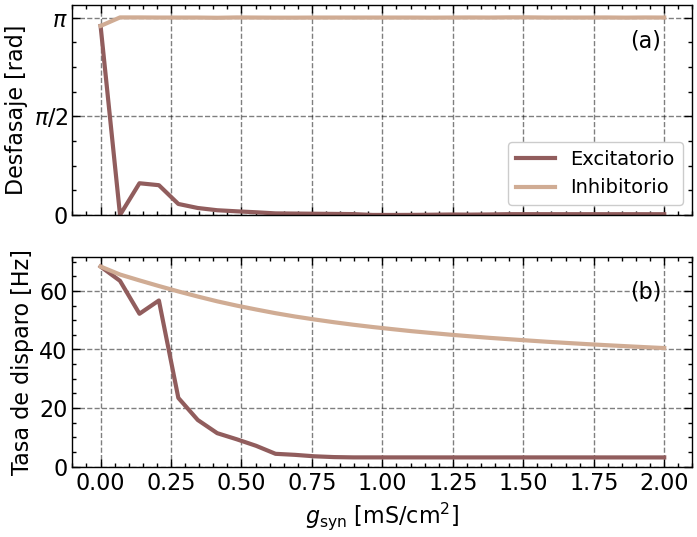

In [88]:
fig, ax = plt.subplots(2, 1, sharex=True)

ms = 4
lw = 3

cm = plt.get_cmap('pink')

ax[0].plot(gsyn_values, desfasajes_exc, label='Excitatorio', lw=lw, ms=ms, color=cm(0.2))
ax[0].plot(gsyn_values, desfasajes_inbh, label='Inhibitorio', lw=lw, ms=ms, color=cm(0.5))
ax[0].set_ylabel('Desfasaje [rad]')
ax[0].set_ylim(0, np.pi+0.2)
ax[0].set_yticks([0, np.pi / 2, np.pi])
ax[0].set_yticklabels(['0', r'$\pi/2$', r'$\pi$'])
ax[0].legend(fontsize=14)

ax[0].text(0.9, 0.8, '(a)', fontsize=16, color='black', transform=ax[0].transAxes)

ax[1].plot(gsyn_values, tasa_disparo_exc, label='Tasa de disparo',lw=lw, ms=ms, color=cm(0.2))
ax[1].plot(gsyn_values, tasa_disparo_inbh, label='Tasa de disparo',lw=lw, ms=ms, color=cm(0.5))
# ax[1].set_yscale('log')
# ax[1].set_xscale('log')
ax[1].set_xlabel(r'$g_\text{syn}$ [mS/cm$^2$]')
ax[1].set_ylabel('Tasa de disparo [Hz]')
ax[1].text(0.9, 0.8, '(b)', fontsize=16, color='black', transform=ax[1].transAxes)

fig.savefig('./doc/figuras/barrido_nsyn.pdf', dpi=300)


Plot dinámica

gsyn = 0.42105263157894735


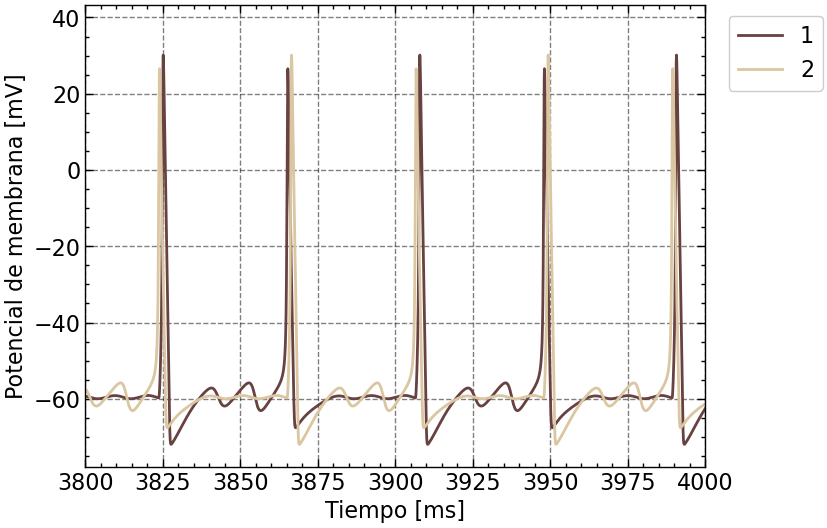

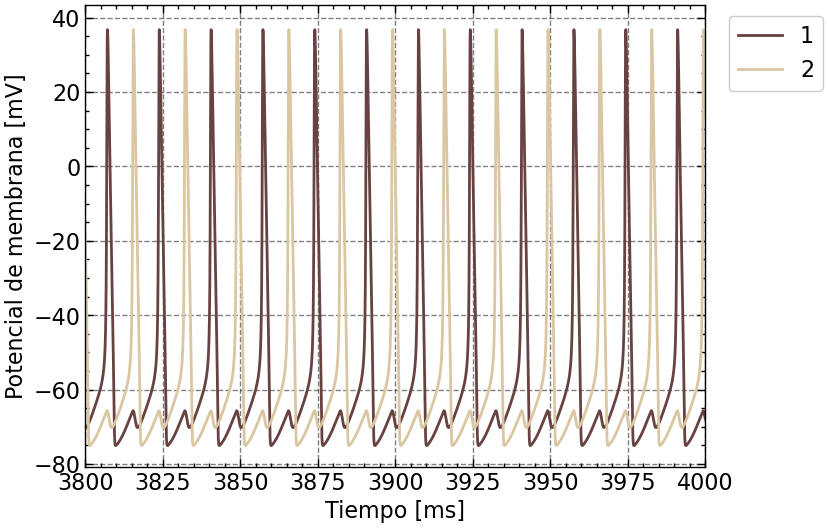

In [56]:
# fig, ax = plt.subplots(2, 1, sharex=True)
i_selec = 4

print(f'gsyn = {gsyn_values[i_selec]}')
x_lims = (3800, 4000)

cm = plt.get_cmap('pink')

plt.figure()
plt.plot(time_axis, results_exc[i_selec, :, 0, 0], label='1', color=cm(0.1))
plt.plot(time_axis, results_exc[i_selec, :, 0, 1], label='2', color=cm(0.6))
plt.xlim(*x_lims)
plt.xlabel('Tiempo [ms]')
plt.ylabel('Potencial de membrana [mV]')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.savefig('./doc/figuras/excitatorio.pdf', bbox_inches='tight', dpi=300)
plt.show()




plt.figure()
plt.plot(time_axis, results_inbh[i_selec, :, 0, 0], label='1', color=cm(0.1))
plt.plot(time_axis, results_inbh[i_selec, :, 0, 1], label='2', color=cm(0.6))
plt.xlim(*x_lims)
plt.xlabel('Tiempo [ms]')
plt.ylabel('Potencial de membrana [mV]')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.savefig('./doc/figuras/inhibitorio.pdf', bbox_inches='tight', dpi=300)
plt.show()